In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from PIL import ImageFile

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# import zipfile, os

# zip_path = "/content/drive/MyDrive/FoodX-251.v4i.folder.zip"
# extract_path = "/content/drive/MyDrive/datasets"

# os.makedirs(extract_path, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Ekstrak berhasil ke :", extract_path)
# print("Isi folder :", os.listdir(extract_path))

In [24]:
n_classes = 10
img_width, img_height = 224, 224
train_data_dir = '/content/drive/MyDrive/datasets/train_set'
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

# Generator for training data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='nearest'
)

# Generator for validation data
validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='nearest'
)

# PIL untuk handle truncated images

ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 1261 images belonging to 10 classes.
Found 533 images belonging to 10 classes.


In [25]:
# train_generator = train_datagen.flow_from_directory(train_data_dir,
#                                                     target_size=(img_width, img_width),
#                                                     batch_size=batch_size,
#                                                     shuffle=True,
#                                                     class_mode='categorical',
#                                                    subset='training')
# test_generator= train_datagen.flow_from_directory(train_data_dir,
#                                                  target_size=(img_width, img_width),
#                                                  batch_size=batch_size,
#                                                  shuffle=False,
#                                                  class_mode='categorical',
#                                                 subset='validation')
# validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
#                                                               target_size=(img_width, img_width),
#                                                               batch_size=batch_size,
#                                                               shuffle=False,
#                                                               class_mode='categorical'
#                                                              )

In [26]:
resnet = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

In [27]:
# from keras.callbacks import LearningRateScheduler
# def learning_rate_scheduler(epoch, lr):
#     initial_lr = 0.00005
#     warmup_epochs = 10  # epochs for warm-up

#     if epoch < warmup_epochs:
#         return initial_lr * (epoch + 1) / warmup_epochs
#     elif epoch == warmup_epochs:
#         # Reducing learning rate
#         return initial_lr / 10
#     else:
#         # After warmup
#         return initial_lr / 10

# # from keras.callbacks import LearningRateScheduler
# # def learning_rate_scheduler(epoch, lr):
# #     initial_lr=0.00005
# #     warmup_epochs = 10 # epoch untuk warm-up
# #     if epoch ==10:
# #         lr = initial_lr /10

# #         return lr
# #     else:
# #         return initial_lr


# lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

In [29]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(
    n_classes,
    kernel_regularizer=regularizers.l2(0.001),
    activation='softmax'
)(x)

model = Model(inputs=resnet.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.fit(train_generator,
#         steps_per_epoch = 83051 // batch_size,
#         validation_data = validation_generator,
#         validation_steps = 11994 // batch_size,
#         epochs=20,
#         verbose=1,
#       callbacks=[ lr_scheduler,checkpointer]
#          )

In [30]:
def learning_rate_scheduler(epoch, lr):
    initial_lr = 0.00005
    warmup_epochs = 10
    if epoch < warmup_epochs:
        return initial_lr * (epoch + 1) / warmup_epochs
    elif epoch == warmup_epochs:
        return initial_lr / 10
    else:
        return initial_lr / 10

lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

checkpointer = ModelCheckpoint(
    filepath='./resnet_best_model10.keras',
    verbose=1,
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    callbacks=[lr_scheduler, checkpointer, early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1083 - loss: 2.5534
Epoch 1: val_accuracy improved from -inf to 0.20826, saving model to ./resnet_best_model10.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 1050s 12s/step - accuracy: 0.1088 - loss: 2.5516 - val_accuracy: 0.2083 - val_loss: 2.1731 - learning_rate: 5.0000e-06
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3301 - loss: 1.9942 
Epoch 2: val_accuracy improved from 0.20826 to 0.60225, saving model to ./resnet_best_model10.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 837s 11s/step - accuracy: 0.3315 - loss: 1.9917 - val_accuracy: 0.6023 - val_loss: 1.5082 - learning_rate: 1.0000e-05
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6598 - loss: 1.2640
Epoch 3: val_accuracy improved from 0.60225 to 0.81426, saving model to ./resnet_best_model10.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 830s 11s/step - accuracy: 0.6604 - loss: 1.2624 - val_accuracy: 0.8143 - val_loss: 0.9033 - learning_rate: 1.5000e-05
Epoch 4/20
79/79 ━━━━━━━━━

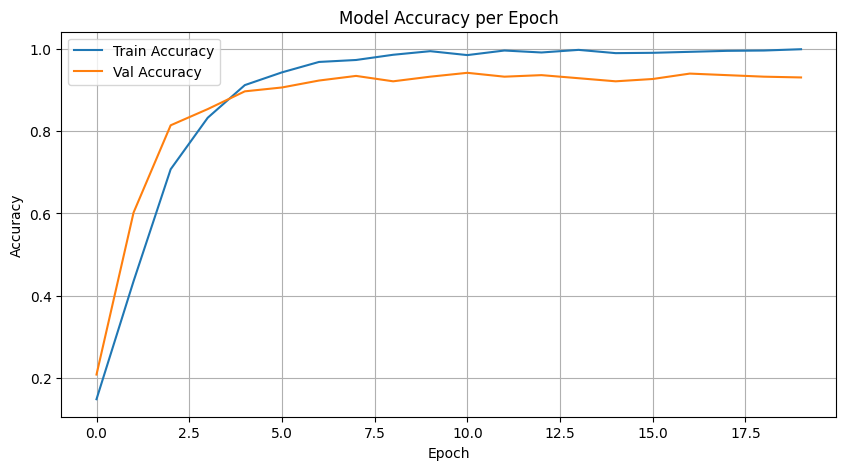

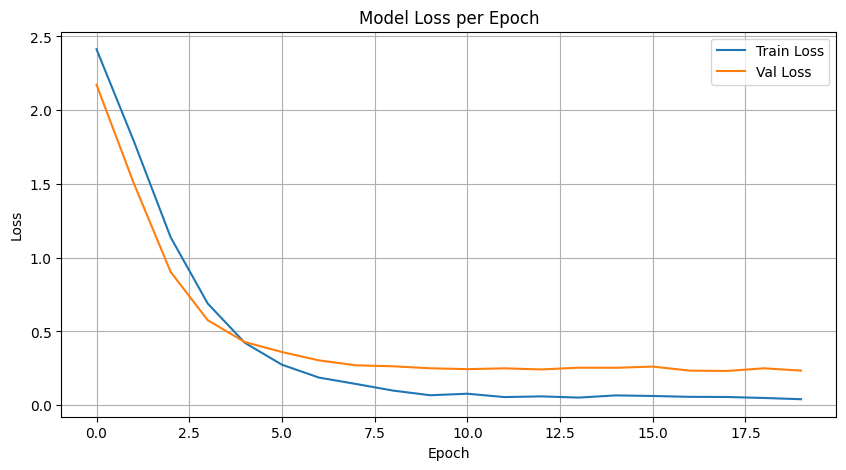

In [31]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.0 MB/s eta 0:00:00


In [ ]:
# # y_true = test_generator.classes

# # prediction = model.predict(test_generator)
# # y_pred = np.argmax(prediction, axis=1)

# import streamlit as st
# from tensorflow.keras.preprocessing import image
# from PIL import Image

# # Load model
# model_food = tf.keras.models.load_model("resnet_best_model10.keras")

# food_classes = ["apel", "apem", "bakpia", "jeruk", "kue pastel", "lemper", "onde-onde", "putu ayu", "risol", "roti"]

# st.title("Food Category Detection")

# # Upload image
# img_file = st.file_uploader("Upload Foto", type=["jpg", "png", "jpeg"])
# camera_file = st.camera_input("Atau gunakan Kamera")

# if img_file or camera_file:
#     img = Image.open(img_file or camera_file).convert("RGB")
#     st.image(img, caption="Gambar Input", use_column_width=True)

#     # Preprocess
#     img_resized = img.resize((224,224))
#     x = np.expand_dims(np.array(img_resized)/255.0, axis=0)

#     # Predict
#     food_pred = np.argmax(model_food.predict(x), axis=1)[0]

#     st.subheader("Hasil Prediksi")
#     st.write("Food Category:", food_classes[food_pred])

2025-09-04 16:22:22.369 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.838 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-04 16:22:22.839 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.841 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 16:22:22.843 Thread 'MainThread': mi

In [38]:
# label_map = {}
# with open('/kaggle/input/ifood-2019-fgvc6/class_list.txt', 'r') as f:
#     for line in f:
#         numerical_label, actual_label = line.strip().split()
#         label_map[int(numerical_label)] = actual_label

# # Convert numerical labels to actual labels
# y_true = [label_map[label] for label in y_true]
# y_pred = [label_map[label] for label in y_pred]

# # Generate the classification report
# report = classification_report(y_true, y_pred,zero_division=1)



# print(report)